In [1]:
import json

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
from mlx_vlm import apply_chat_template, generate, load
from mlx_vlm.utils import load_image
from PIL import Image


This is a beta version of the video understanding. It may not work as expected.


# Image Description

Load the Qwen2.5-VL model and processor

In [2]:
model_path = "mlx-community/Qwen2.5-VL-3B-Instruct-bf16"
model, processor = load(model_path)
config = model.config

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Show input image

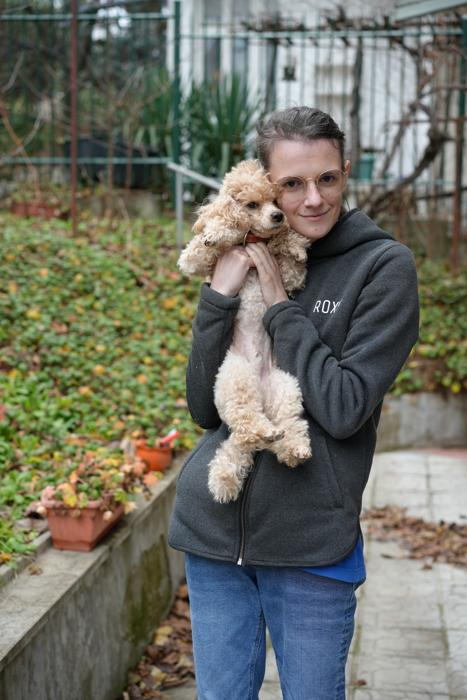

In [3]:
image_path = "./images/person_dog.jpg"
image = load_image(image_path)
image

In [4]:
image.size

(467, 700)

Prepare image input and prompt

In [5]:
prompt = "Describe the image."

Apply chat template

In [6]:
formatted_prompt = apply_chat_template(
    processor, config, prompt, num_images=1
)

Generate output

In [7]:
output = generate(model, processor, formatted_prompt, image, verbose=True)

Files: <PIL.Image.Image image mode=RGB size=467x700 at 0x5587A1E50> 

Prompt: <|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
Describe the image.<|vision_start|><|image_pad|><|vision_end|><|im_end|>
<|im_start|>assistant

The image shows a person standing outdoors, holding a small, fluffy, light-colored dog. The person is wearing a dark gray hoodie with the word "ROX" on it and blue jeans. The background features a garden with various plants and a fence, and there are some fallen leaves on the ground. The setting appears to be a residential area with a garden.
Prompt: 450 tokens, 188.212 tokens-per-sec
Generation: 74 tokens, 21.156 tokens-per-sec
Peak memory: 8.558 GB


In [8]:
print(output)

The image shows a person standing outdoors, holding a small, fluffy, light-colored dog. The person is wearing a dark gray hoodie with the word "ROX" on it and blue jeans. The background features a garden with various plants and a fence, and there are some fallen leaves on the ground. The setting appears to be a residential area with a garden.


# Spatial Understanding

In [9]:
system_prompt="You are a helpful assistant"
prompt="Outline the position of ecah object and output all the bbox coordinates in JSON format."
messages = [
    {
      "role": "system",
      "content": system_prompt
    },
    {
      "role": "user",
      "content": [
        {
          "type": "text",
          "text": prompt
        },
        {
          "type": "image",
          "image": image_path,
        }
      ]
    }
  ]
prompt = apply_chat_template(processor, config, messages, tokenize=False)

In [10]:
output = generate(
    model,
    processor,
    prompt,
    image,
    max_tokens=1024,
    # temperature=0.7,
    verbose=True
)

Files: <PIL.Image.Image image mode=RGB size=467x700 at 0x5587A1E50> 

Prompt: <|im_start|>system
You are a helpful assistant<|im_end|>
<|im_start|>user
[{'type': 'text', 'text': 'Outline the position of ecah object and output all the bbox coordinates in JSON format.'}, {'type': 'image', 'image': './images/person_dog.jpg'}]<|vision_start|><|image_pad|><|vision_end|><|im_end|>
<|im_start|>assistant

```json
[
  {
    "bbox_2d": [171, 105, 428, 699],
    "label": "person holding a dog"
  },
  {
    "bbox_2d": [180, 158, 318, 504],
    "label": "dog"
  }
]
```
Prompt: 492 tokens, 312.234 tokens-per-sec
Generation: 86 tokens, 20.257 tokens-per-sec
Peak memory: 8.558 GB


In [11]:
print(output)

```json
[
  {
    "bbox_2d": [171, 105, 428, 699],
    "label": "person holding a dog"
  },
  {
    "bbox_2d": [180, 158, 318, 504],
    "label": "dog"
  }
]
```


### Plot bounding boxes

In [12]:
def parse_bbox(bbox_str):
    return json.loads(bbox_str.replace("```json", "").replace("```", ""))

In [13]:
def normalize_bbox(processor, image, x_min, y_min, x_max, y_max):
    width, height = image.size
    _, input_height, input_width = (
        processor.image_processor(image)["image_grid_thw"][0] * 14
    )

    x_min_norm = int(x_min / input_width * width)
    y_min_norm = int(y_min / input_height * height)
    x_max_norm = int(x_max / input_width * width)
    y_max_norm = int(y_max / input_height * height)

    return x_min_norm, y_min_norm, x_max_norm, y_max_norm


In [14]:
def plot_image_with_bboxes(processor, image, bboxes):
    image = Image.open(image) if isinstance(image, str) else image
    _, ax = plt.subplots(1)
    ax.imshow(image)

    if isinstance(bboxes, list) and all(isinstance(bbox, dict) for bbox in bboxes):
        colors = plt.cm.rainbow(np.linspace(0, 1, len(bboxes)))

        for i, (bbox, color) in enumerate(zip(bboxes, colors)):
            label = bbox.get("label", None)
            x_min, y_min, x_max, y_max = bbox.get("bbox_2d", None)

            x_min_norm, y_min_norm, x_max_norm, y_max_norm = normalize_bbox(
                processor, image, x_min, y_min, x_max, y_max
            )
            width = x_max_norm - x_min_norm
            height = y_max_norm - y_min_norm

            rect = patches.Rectangle(
                (x_min_norm, y_min_norm),
                width,
                height,
                linewidth=2,
                edgecolor=color,
                facecolor="none",
            )
            ax.add_patch(rect)
            ax.text(
                x_min_norm,
                y_min_norm,
                label,
                color=color,
                fontweight="bold",
                bbox=dict(facecolor="white", edgecolor=color, alpha=0.8),
            )

    plt.axis("off")
    plt.tight_layout()

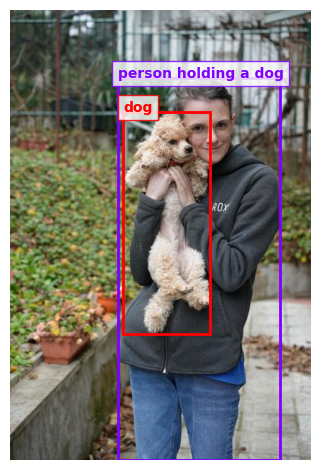

In [15]:
objects_data = parse_bbox(output)
plot_image_with_bboxes(processor, image, bboxes=objects_data)